In [1]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

In [2]:
!pip install pbd

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type
from torch.nn.parameter import Parameter
import pdb

In [0]:
import math

In [28]:
#--------------------------------PART 1--------------------------------
class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, 
               padding=0, dilation=1, groups=1, bias=True, init_type=0):
    self.__dict__.update(locals())
    super(Conv2d, self).__init__()
    
    #(out, in, k, k)
    self.weight = Parameter(torch.Tensor(out_channels, in_channels, *kernel_size))
    self.bias = Parameter(torch.Tensor(out_channels))
    self.bias.data.uniform_(0,0)

    
    
    #--------------------------------PART 2--------------------------------
    if(init_type == 0):
     #Uniform Initialization
      self.weight.data.uniform_(-0.1,0.1)
    elif(init_type == 1):
     #Xe Initialization
      self.weight.data.normal_(-(1 / math.sqrt(in_channels)), 1 / math.sqrt(in_channels))
    elif(init_type == 2):
     #Orthogonal Optimization
      print("Orthogonal")
      X = np.random.randn((*self.weight.size()))
      U, _, Vt = np.linalg.svd(X, full_matrices=False)
      W = Vt.reshape((*self.weight.size())).astype(np.float32)
      self.weight.data = torch.from_numpy(W)
      
      
    
    
  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride, 
                    self.padding, self.dilation, self.groups)
  
  

class ConvNetwork(nn.Module):
  def __init__(self, dataset, in_type):
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    output = 150
    
    self.net = nn.Sequential(
              Conv2d(c, 10, (3,3), padding=(1,1), init_type=in_type),
#               nn.ReLU(),
#               Conv2d(10, 30, (3,3), padding=(1,1), init_type=in_type),
#               nn.ReLU(),
#               Conv2d(30, 60, (3,3), padding=(1,1), init_type=in_type),
#               nn.ReLU(),
#               Conv2d(60, 10, (3,3), padding=(1,1), init_type=in_type),
              nn.ReLU(),
              Conv2d(10, output, (28,28), padding=(0,0), init_type=in_type)
              )
    
    
  def forward(self, x):
    return self.net(x).squeeze(2).squeeze(2)
  

#TODO:
class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='elementwise_mean'):
    super(CrossEntropyLoss, self).__init__()
    self.__dict__.update(locals())
    
    
  def forward(self, y_hat, true_index):
    max_col = torch.max(y_hat, 1, keepdim=True)[0]
#     print(y_hat)
    new_y_hat = y_hat - max_col
#     print(new_y_hat)
    probs = torch.exp(new_y_hat)
#     print(probs) 
    logprob = torch.log(probs/probs.sum(1, keepdim=True))
#     print(logprob)
    neg_log_probs = -logprob[torch.arange(y_hat.size(0)).long(), true_index].mean()
#     print(neg_log_probs)
    return neg_log_probs
  
  
class FashionMNISTProcessedData(Dataset):
   def __init__(self, root, train=True):
      self.data = datasets.FashionMNIST(root,
                                       train=train,
                                       transform = transforms.ToTensor(),
                                       download=True)
   def __getitem__(self, i):
    x, y = self.data[i]
#     pdb.set_trace()
    return x, y
    
      
   def __len__(self):
    return len(self.data)
    
    

train_dataset = FashionMNISTProcessedData('/tmp/fashionnmist', True)    
validation_dataset = FashionMNISTProcessedData('/tmp/fashionnmist', False)
  

objective = CrossEntropyLoss()

train_loader = DataLoader(train_dataset,
                         batch_size=42,
                         pin_memory=True)
validation_loader = DataLoader(validation_dataset,
                               batch_size=42,
                               pin_memory=True)

epochs = []
types_ = ['Uniform Initialization','Xavier Initialization','Orthogonal Initialization']

for epoch in range(3):
  training_losses = []
  validation_losses = []
  train_accuracys = []
  val_accuracys = []
  model = ConvNetwork(train_dataset,epoch)
  model.cuda()
  optimizer = optim.Adam(model.parameters(), lr=1e-4)
  
  loop = tqdm(total=len(train_loader), position=0)
  
  for i,(x,y_truth) in enumerate(train_loader):
    
    x = x.cuda(async=True)
    y_truth = y_truth.cuda(async=True )

    optimizer.zero_grad()
    
    y_hat = model(x)
    loss = objective(y_hat, y_truth)
#     print(loss)
#     break
    loss.backward()
    
    training_losses.append(loss.item())
    #TODO:
#     print(y_hat)
    train_accuracy = (y_truth.eq(torch.argmax(y_hat, 1))).float().mean() #np.argmax(y_hat, axis=1) 
    train_accuracys.append((len(training_losses),train_accuracy))
    
    loop.set_description('epoch:{}, loss:{:.4f}, accuracy{:.3f}'.format(epoch+1, training_losses[i], train_accuracy))
    loop.update(1)
    optimizer.step()
    
    with torch.no_grad():
      validation_loss = []
      if(i % 100 == 0):
        for val_x1,val_y1_truth in validation_loader:

          val_x1 = val_x1.cuda(async=True)
          val_y1_truth = val_y1_truth.cuda(async=True )

          val_y1_hat = model(val_x1)
          v_loss = objective(val_y1_hat, val_y1_truth)

          validation_loss.append(v_loss)

        val_loss = [x.item() for x in validation_loss]
        validation_losses.append((len(training_losses),sum(val_loss)/len(val_loss)))
      
        val_accuracy = (val_y1_truth.eq(torch.argmax(val_y1_hat, 1).long())).float().mean()
        val_accuracys.append((len(training_losses), val_accuracy))
      
  loop.close()
  
  epochs.append((epoch, types_[epoch], training_losses, validation_losses, sum([np.prod(p.size()) for p in  model.parameters()]), train_accuracys, val_accuracys))
  
  
  

  

epoch:2, loss:0.6733, accuracy0.750: 100%|██████████| 1429/1429 [01:17<00:00, 18.53it/s]


Orthogonal
Orthogonal


epoch:3, loss:0.8863, accuracy0.708: 100%|██████████| 1429/1429 [01:17<00:00, 18.51it/s]


Number of Parameters: 1176250


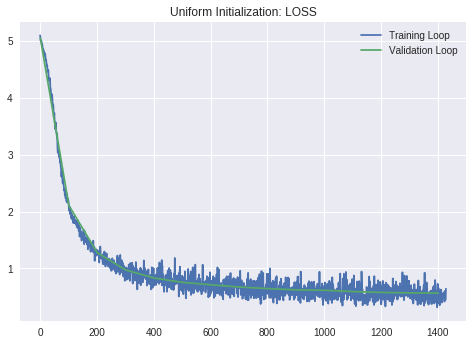

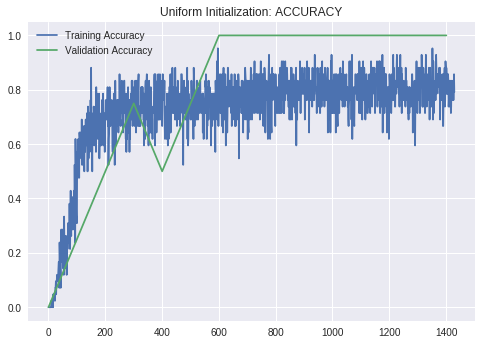

Number of Parameters: 1176250


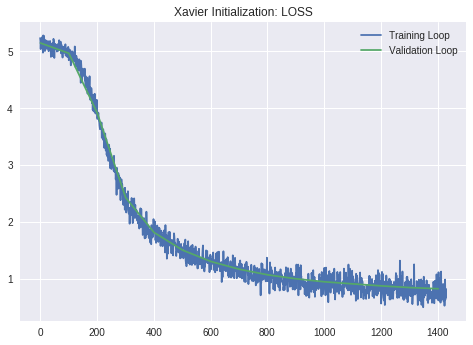

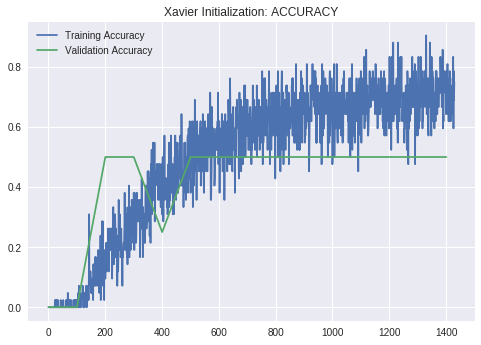

Number of Parameters: 1176250


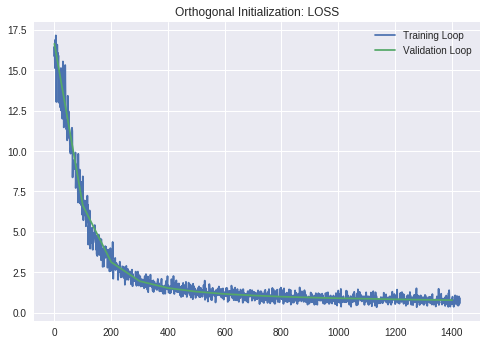

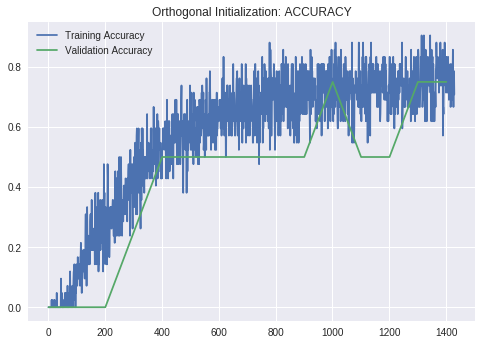

In [29]:
#--------------------------------Part 3--------------------------------  
for epoch in epochs:
  print("Number of Parameters:", epoch[4])
  x, y = zip(*epoch[3])
  x1, y1 = zip(*epoch[5])
  x2, y2 = zip(*epoch[6])
  plt.plot(epoch[2], label='Training Loop')
  plt.plot(x, y, label='Validation Loop')
  plt.legend()
  plt.title(epoch[1] + ": LOSS")
  plt.show()
  
  plt.plot(x1 , y1, label='Training Accuracy')
  plt.plot(x2 , y2, label='Validation Accuracy')
  plt.legend()
  plt.title(epoch[1] + ": ACCURACY")
  plt.show()

--------------------------------Part 4--------------------------------

Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)

(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))

(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) :  (out_channels=22, kernel_size=(3, 3), padding=(1,1))

(c=3, h=10, w=10) ⇒ (c=65, h=11, w=11) : (out_channels=65, kernel_size=(3, 3), padding=(2, 1))

(c=3, h=10, w=10) ⇒ (c=7, h=15, w=15) : (out_channels=7, kernel_size=(3, 3), padding=(4, 3))

Using a Kernel size of 5×5:

(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))

(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 5), padding=(2, 2))

(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 5), padding=(4, 3))

(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 5), padding=(9, 9))

Using Kernel size of 5×3:

(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 3), padding=(1, 0))

(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 3), padding=(2, 1))

(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 3), padding=(3, 2))

(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 3), padding=(9, 8))

Determine the kernel that requires the smallest padding size to make the following mappings possible:

(c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : (out_channels=10, kernel_size=(2, 4), padding=(0, 0))

(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(1, 1), padding=(0, 0))